In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
import sklearn
import os

In [20]:

os.listdir()

['.ipynb_checkpoints',
 'app.py',
 'Brainrot.ipynb',
 'data',
 'index.html',
 'model.keras']

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
data=tf.keras.utils.image_dataset_from_directory('data')


Found 7023 files belonging to 3 classes.


In [6]:
import os
import shutil
import random

# Define directories
train_dir = 'data/training'
val_dir = 'data/validation'
split_ratio = 0.2  # Percentage of training data to move to validation

# Create validation directory structure if it doesn't exist
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    val_class_path = os.path.join(val_dir, class_name)

    # Create class directory in validation folder if it doesn't exist
    if not os.path.exists(val_class_path):
        os.makedirs(val_class_path)

    # List all files in the class directory
    images = os.listdir(class_path)

    # Check the existing validation images
    existing_val_images = set(os.listdir(val_class_path)) if os.path.exists(val_class_path) else set()
    
    # Move only if the validation set is empty or does not contain enough images
    if len(existing_val_images) < int(len(images) * split_ratio):
        # Filter out images that are already in the validation set
        images = [img for img in images if img not in existing_val_images]

        # Shuffle and select images for validation
        random.shuffle(images)
        num_val_images = int(len(images) * split_ratio)

        # Move the selected images to validation directory
        for i in range(num_val_images):
            src = os.path.join(class_path, images[i])
            dst = os.path.join(val_class_path, images[i])
            shutil.move(src, dst)  # Move the file

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators
train_datagen = ImageDataGenerator(rescale=1.0/255) 
test_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

# Load training data
train_data = train_datagen.flow_from_directory(
    'data/training',  
    target_size=(150, 150),  
    batch_size=32,  
    class_mode='categorical'  
)

# Load testing data from 'test' folder
test_data = test_datagen.flow_from_directory(
    'data/testing', 
    target_size=(150, 150),  
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
val_data = val_datagen.flow_from_directory(
    'data/validation',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 4571 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [7]:
len(data)

220

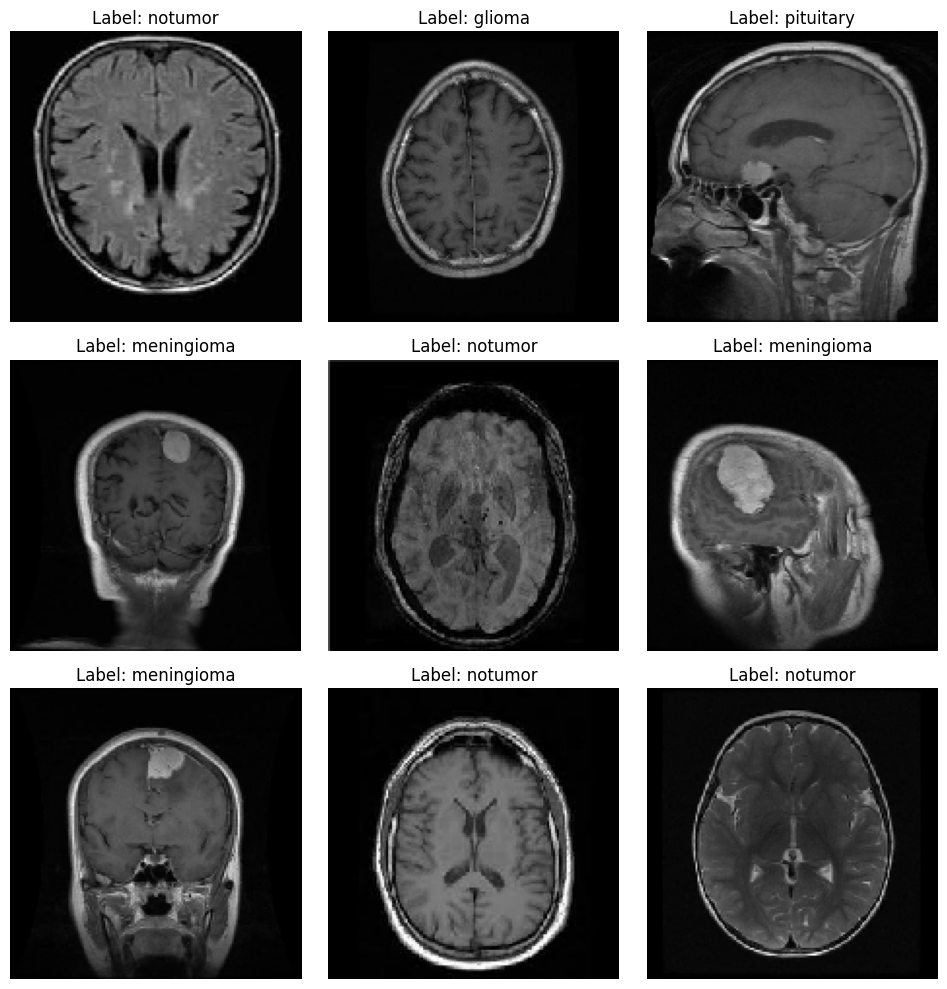

In [8]:
images, labels = next(train_data)
class_indices = train_data.class_indices
class_names = list(class_indices.keys())

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    label = np.argmax(labels[i])  # Get the index of the class from one-hot encoded labels
    plt.title(f"Label: {class_names[label]}")
    plt.tight_layout()
plt.show()

In [9]:
model = models.Sequential([
    layers.Input(shape=(150, 150, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,833,476 (129.06 MB)

 Trainable params: 33,833,476 (129.06 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\Daksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


41/41 ━━━━━━━━━━━━━━━━━━━━ 14s 344ms/step


<Figure size 1000x1000 with 0 Axes>

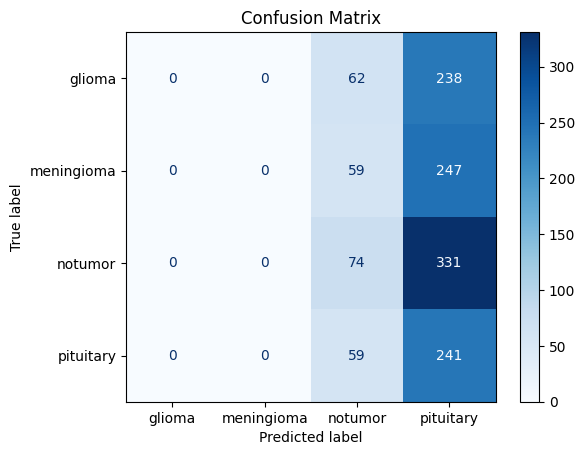

In [11]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
predictions=model.predict(test_data)
predicted_classes=np.argmax(predictions,axis=1)
true_classes=test_data.classes
cm=confusion_matrix(true_classes,predicted_classes)
plt.figure(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 69, 69, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,833,476 (129.06 MB)

 Trainable params: 33,833,476 (129.06 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    train_data,
    epochs=30,
    validation_data=val_data,
    callbacks=[early_stopping]
)
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module=r".*keras.*")




Epoch 1/30


c:\Users\Daksh\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


143/143 ━━━━━━━━━━━━━━━━━━━━ 117s 788ms/step - accuracy: 0.5347 - loss: 1.1768 - val_accuracy: 0.7897 - val_loss: 0.5181
Epoch 2/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 96s 673ms/step - accuracy: 0.7970 - loss: 0.4912 - val_accuracy: 0.8624 - val_loss: 0.3724
Epoch 3/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 97s 679ms/step - accuracy: 0.8721 - loss: 0.3356 - val_accuracy: 0.8764 - val_loss: 0.3468
Epoch 4/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 99s 688ms/step - accuracy: 0.9030 - loss: 0.2558 - val_accuracy: 0.9018 - val_loss: 0.2863
Epoch 5/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9302 - loss: 0.1855 - val_accuracy: 0.9045 - val_loss: 0.2781
Epoch 6/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 730ms/step - accuracy: 0.9494 - loss: 0.1329 - val_accuracy: 0.9273 - val_loss: 0.2206
Epoch 7/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 105s 731ms/step - accuracy: 0.9650 - loss: 0.1047 - val_accuracy: 0.9351 - val_loss: 0.2249
Epoch 8/30
143/143 ━━━━━━━━━━━━━━━━━━━━ 106s 737ms/step - accuracy: 0.9732 - loss: 0.0752 - v

In [14]:
test_loss,test_acc=model.evaluate(test_data)
print(test_acc)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.9266 - loss: 0.2162
0.9313501119613647


In [19]:
model.save('model.keras')